In [1]:
# Copying in code from bridges to run CNN DS1J test on laptop.

In [13]:
### Note: Place code in directory, with the folder for images and a folder for output files on the same level.

# Importing modules to build, train, and test model
import os
import stat
import matplotlib
#from matplotlib import pyplot as plt
#from matplotlib.pyplot import figure
#import matplotlib.image as mpimg
#import matplotlib.ticker as mtick
import numpy as np
import imageio as im
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.callbacks import ModelCheckpoint, EarlyStopping
import math
import PIL
from PIL import Image

# Importing modules to build heatmap
from keras.applications.inception_v3 import InceptionV3,preprocess_input,decode_predictions
from keras.layers import Input
from keras import activations
from keras.models import load_model
from keras.layers import GlobalAveragePooling2D
from keras import initializers
from keras.models import Model
from keras.utils import multi_gpu_model
import matplotlib.cm as cm
import random as python_random

from keras.applications import imagenet_utils
import h5py
import argparse

#from vis.visualization import overlay,visualize_cam,visualize_activation,visualize_saliency
#from vis.utils import utils

import imageio
import time
import ntpath
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

print("All loaded!")

# Clearing the memory for a fresh start and prevention of slowdown
keras.backend.clear_session()

np.random.seed(123)
python_random.seed(123)
tf.random.set_seed(1234)

# construct the argument parse and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-r", "--rounds", type=int, default=1,
#  help="round number")
#args = vars(ap.parse_args())

# grab the number of GPUs and store it in a conveience variable
#R = args["rounds"]

All loaded!


In [3]:
# Defining directories to make easier to reference later on:

cwd = os.getcwd()
training_dir = "D:\\DS_Datasets\\Updated_DS_AVI\\DS1\\DS1J_split\\train"
testing_dir = "D:\\DS_Datasets\\Updated_DS_AVI\\DS1\\DS1J_split\\test"
validation_dir = "D:\\DS_Datasets\\Updated_DS_AVI\\DS1\\DS1J_split\\val"
output_dir = cwd + "/output"
weights_dir = '/outputs/boiling_weights.hdf5'
classifier_dir = cwd + "/outputs/boiling_model.h5"
#output_dir = "/images"

# Creating (and downscaling) the location for the image data to be stored
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

# Setting the image/batch parameters to change easily if need be
# Certain parameters later on typically depend on these values
image_width = 128
image_height = 128
batch_size = 25

In [4]:
# Taking in the image data from a given directory
# The classes are automatically set based on how the folders are arranged
training_set = train_datagen.flow_from_directory(training_dir,
                                                 target_size = (image_width, image_height),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(testing_dir,
                                            target_size = (image_width, image_height),
                                            batch_size = 1,
                                            shuffle=False,
                                            class_mode = 'categorical')

validation_set = val_datagen.flow_from_directory(validation_dir,
                                                 target_size = (image_width, image_height),
                                                 batch_size = batch_size,
                                                 shuffle=True,
                                                 class_mode = 'categorical')

Found 7539 images belonging to 22 classes.
Found 2371 images belonging to 22 classes.
Found 1879 images belonging to 22 classes.


In [5]:
classifier = Sequential()

# Adding the first convolutional layer
classifier.add(Conv2D(32, (3, 3), padding='same', input_shape = (128, 128, 3), activation = 'relu'))
classifier.add(Conv2D(32, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.5)) # antes era 0.25

# Adding a second convolutional layer
classifier.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
classifier.add(Conv2D(64, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.5)) # antes era 0.25

# Adding a third convolutional layer
classifier.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
classifier.add(Conv2D(64, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.5)) # antes era 0.25

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(units = 512, activation = 'relu'))
classifier.add(Dropout(0.5)) 
classifier.add(Dense(units = 22, activation = 'softmax', name='visualized_layer')) 
                     # Note that the units here should
                     # be equal to number of classes

In [6]:
# Simply prints an overview of the model
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)       

In [7]:
classifier.compile(optimizer = 'rmsprop',
                   loss = 'categorical_crossentropy',
                   metrics = ['accuracy'])


In [8]:
# Setting up a checkpoint such that after every cycle of the CNN, 
# the best parameters (weights) will be saved
checkpointer = ModelCheckpoint(filepath="cnn_boiling_1.0.0.hdf5", 
                               monitor = 'loss',
                               verbose=1, 
                               save_best_only=True)

# Prepare callback for training time.
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times=[]
    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start=time.time()
    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()
earlystop = EarlyStopping(patience=7)
callbacks = [time_callback, checkpointer, earlystop]

In [9]:
# As mentioned above, certain parameters of the model are based on ratios between the size
# of the samples, batch, etc.

# Number of epochs is kept relatively low (to run quicker and diagnose problems), 
# but can be increased for actual use later on
history = classifier.fit_generator(training_set,
                                   steps_per_epoch = math.ceil(training_set.n/training_set.batch_size),
                                   epochs = 30,
                                   callbacks=callbacks,
                                   validation_data = validation_set,
                                   validation_steps = math.ceil(validation_set.n/validation_set.batch_size),
                                   shuffle=True)

Epoch 1/30
302/302 [==============================] - 253s 839ms/step - loss: 2.3974 - accuracy: 0.2755 - val_loss: 1.0672 - val_accuracy: 0.5705

Epoch 00001: loss improved from inf to 2.39860, saving model to cnn_boiling_1.0.0.hdf5
Epoch 2/30
302/302 [==============================] - 250s 828ms/step - loss: 1.3295 - accuracy: 0.5482 - val_loss: 1.4685 - val_accuracy: 0.6099

Epoch 00002: loss improved from 2.39860 to 1.32970, saving model to cnn_boiling_1.0.0.hdf5
Epoch 3/30
302/302 [==============================] - 250s 826ms/step - loss: 0.9014 - accuracy: 0.6838 - val_loss: 0.5747 - val_accuracy: 0.7855

Epoch 00003: loss improved from 1.32970 to 0.90192, saving model to cnn_boiling_1.0.0.hdf5
Epoch 4/30
302/302 [==============================] - 249s 825ms/step - loss: 0.7055 - accuracy: 0.7492 - val_loss: 0.2229 - val_accuracy: 0.8047

Epoch 00004: loss improved from 0.90192 to 0.70532, saving model to cnn_boiling_1.0.0.hdf5
Epoch 5/30
302/302 [==============================] 

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

times = time_callback.times

filename = r"output_ds1j_laptop.txt"

output_file = open(filename, "w")

print("Output file opened")

output_file.write("loss\n")
for i in range(len(loss)):
    output_file.write(str(loss[i]))
    output_file.write("\n")
output_file.write("\nval_loss\n")
for i in range(len(val_loss)):
    output_file.write(str(val_loss[i]))
    output_file.write("\n")
output_file.write("\naccuracy\n")
for i in range(len(accuracy)):
    output_file.write(str(accuracy[i]))
    output_file.write("\n")
output_file.write("\nval_accuracy\n")
for i in range(len(val_accuracy)):
    output_file.write(str(val_accuracy[i]))
    output_file.write("\n")
output_file.write("\nTotal time\n")
output_file.write(str(np.sum(times)))
output_file.write("\nAverage time\n")
output_file.write(str(np.sum(times)/len(times)))
    
output_file.close()

print("Output file closed")

times = time_callback.times
print("Total time: ", np.sum(times))
print("Average time: ", np.sum(times)/len(times))

Output file opened
Output file closed
Total time:  5955.05695438385
Average time:  248.1273730993271


In [11]:
classifier.save("cnn_ds1j_laptop.h5")

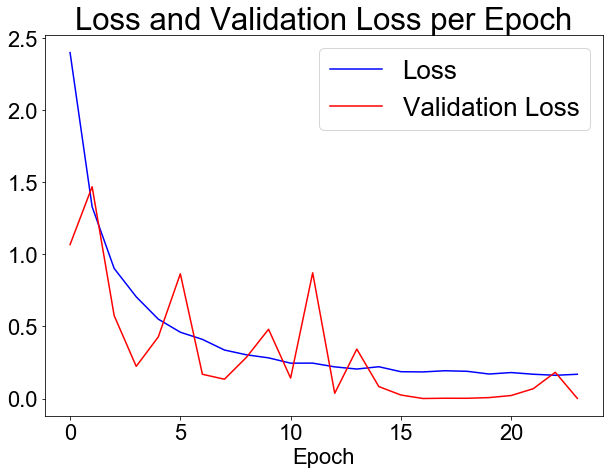

In [14]:
matplotlib.pyplot.figure(figsize=(10,7))
matplotlib.pyplot.rcParams["font.family"] = "Arial"
matplotlib.pyplot.rcParams.update({'font.size': 22})
matplotlib.pyplot.plot(history.history['loss'], label='Loss', color='blue');
matplotlib.pyplot.plot(history.history['val_loss'], label='Validation Loss', color='red');
matplotlib.pyplot.xlabel('Epoch');
matplotlib.pyplot.rcParams.update({'font.size': 26})
matplotlib.pyplot.title('Loss and Validation Loss per Epoch')
matplotlib.pyplot.legend();
matplotlib.pyplot.savefig('cnn_ds1j_laptop.png')

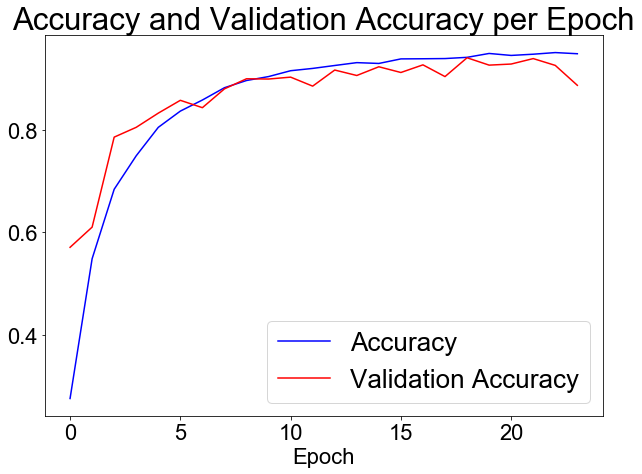

In [15]:
matplotlib.pyplot.figure(figsize=(10,7))
matplotlib.pyplot.rcParams["font.family"] = "Arial"
matplotlib.pyplot.rcParams.update({'font.size': 22})
matplotlib.pyplot.plot(history.history['accuracy'], label='Accuracy', color='blue');
matplotlib.pyplot.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red');
matplotlib.pyplot.xlabel('Epoch');
matplotlib.pyplot.rcParams.update({'font.size': 26})
matplotlib.pyplot.title('Accuracy and Validation Accuracy per Epoch')
matplotlib.pyplot.legend();
matplotlib.pyplot.savefig('cnn_ds1j_laptop.png')

In [16]:
loaded_model = load_model("cnn_ds1j_laptop.h5")

In [21]:
filenames = test_set.filenames
nb_samples = len(filenames)

#predict = classifier.predict_generator(test_set, steps = nb_samples)

In [22]:
predict = loaded_model.predict_generator(test_set, steps=nb_samples)

In [24]:
y_pred_report = np.argmax(predict, axis = 1)
#y_test_report = np.argmax(y_test, axis = 1)

In [25]:
print('Classification Report')
target_names = ["class_00", "class_01", "class_02", "class_03", "class_04",
               "class_05", "class_06", "class_07", "class_08", "class_09",
               "class_10", "class_11", "class_12", "class_13", "class_14",
               "class_15", "class_16", "class_17", "class_18", "class_19",
               "class_20", "class_21"]
print(classification_report(test_set.classes, y_pred_report, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

    class_00       1.00      1.00      1.00       101
    class_01       1.00      0.98      0.99       101
    class_02       0.98      1.00      0.99       101
    class_03       1.00      1.00      1.00       101
    class_04       1.00      1.00      1.00       101
    class_05       1.00      0.99      1.00       101
    class_06       0.93      0.98      0.95       101
    class_07       0.91      0.94      0.93       101
    class_08       0.77      0.94      0.85       101
    class_09       0.75      0.93      0.83       101
    class_10       0.81      0.89      0.85       101
    class_11       0.86      0.64      0.73       101
    class_12       0.70      0.72      0.71       101
    class_13       0.85      0.71      0.77       101
    class_14       0.95      0.81      0.88       101
    class_15       0.96      0.86      0.91       101
    class_16       0.81      0.93      0.87       101
    c

In [26]:
print('Confusion Matrix')
matrix=confusion_matrix(test_set.classes, y_pred_report)
print(matrix)

Confusion Matrix
[[101   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0  99   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0 101   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0 101   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0 101   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   0 100   0   1   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   0   0  99   1   1   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   0   0   3  95   1   2   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   0   0   1   1  95   4   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   0   0   1   4   2  94   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   0   0   3   0   2   6  90   0   0

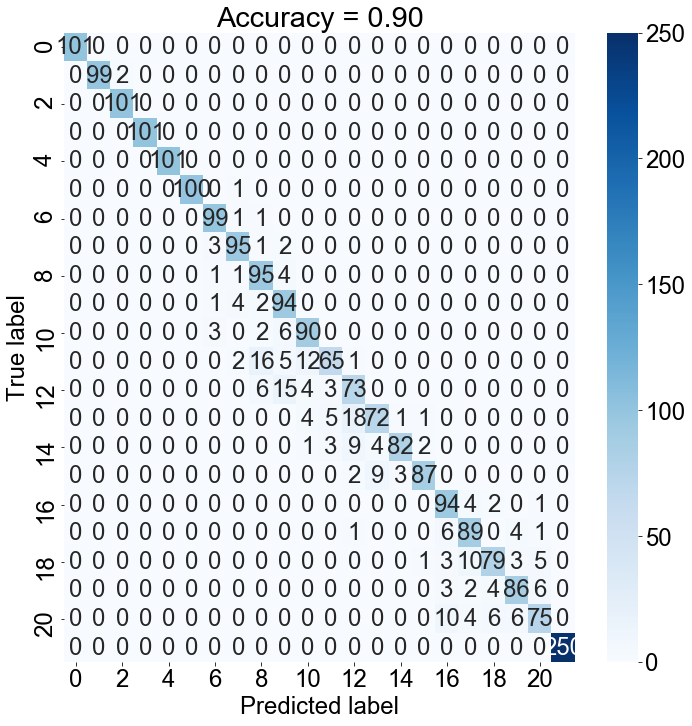

In [28]:
figure = matplotlib.pyplot.figure(figsize=(10, 10))
sns.heatmap(matrix, annot=True,cmap=matplotlib.pyplot.cm.Blues,
           annot_kws={"size": 24}, fmt='d')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.title("Accuracy = 0.90")
matplotlib.pyplot.ylabel('True label')
matplotlib.pyplot.xlabel('Predicted label')
matplotlib.rcParams.update({'font.size': 24})
matplotlib.pyplot.savefig('conmatrix_cnn_ds1j_laptop.png',bbox_inches='tight')
matplotlib.pyplot.show()